# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

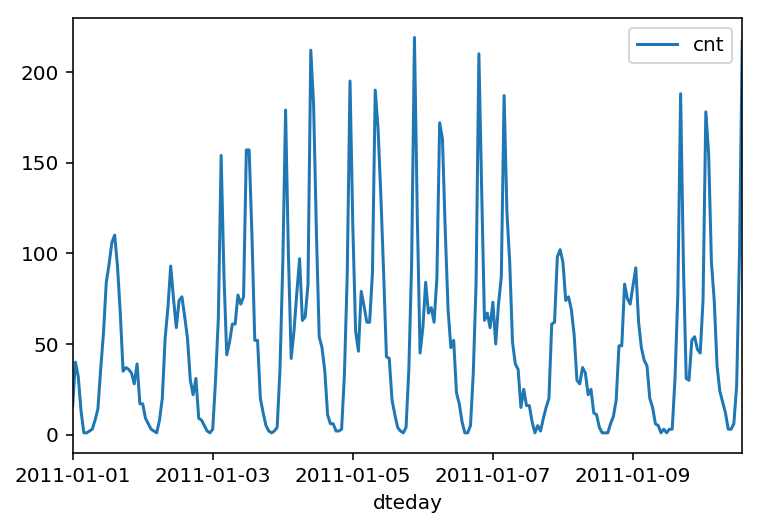

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [59]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        # self.activation_function = lambda x : 0  # Replace 0 with your sigmoid calculation.
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        #def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        #self.activation_function = sigmoid
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))  # Replace 0 with your sigmoid calculation here
        self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        print(targets)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs
            
            #self.activation_function(final_inputs) # signals from final output layer
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.
            
            # TODO: Calculate the hidden layer's contribution to the error
            # hidden_error = np.dot(output_error_term, self.weights_hidden_to_output)
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            output_error_term = error * 1.0 #error * final_outputs * (targets - final_outputs)
            # hidden_error_term = None
            
            #hidden_error = error - hidden_outputs
            hidden_error = np.dot(self.weights_hidden_to_output, error)
            hidden_error_term = hidden_error * hidden_outputs * (1- hidden_outputs)
        
            #np.dot(output_error_term, self.weights_hidden_to_output) * hidden_outputs * (1 - hidden_outputs)

            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:, None]
            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term * hidden_outputs[:, None]

        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += self.lr * delta_weights_h_o #/ n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h #/ n_records # update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        # hidden_inputs = np.dot(self.input_nodes, self.weights_input_to_hidden) # signals into hidden layer
        hidden_inputs =  np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

In [60]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [61]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....

[[ 0.4]]



----------------------------------------------------------------------
Ran 5 tests in 0.005s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, if you use too many iterations, then the model with not generalize well to other data, this is called overfitting. You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. As you start overfitting, you'll see the training loss continue to decrease while the validation loss starts to increase.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [62]:
import sys

### Set the hyperparameters here ###
iterations = 100
learning_rate = 0.1
hidden_nodes = 2
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

11664   -0.983877
3261     0.620422
2257    -0.763355
9190    -0.112814
13775   -0.994903
4663    -0.950799
10553    1.033902
3192    -0.504241
4493    -0.989390
8359    -0.713737
12736    0.477083
4394    -0.851564
4968     0.107708
11740    0.747223
10405    0.918127
5167    -0.961825
6023    -0.030118
1086    -0.868103
12930   -0.167945
6968    -0.449111
1089    -1.000416
2674     1.430842
12583    0.796840
8777     0.080143
12656    2.357035
11010   -0.393980
14403    2.776027
4162     1.419815
14699    2.820132
5592    -0.234101
           ...   
8753    -0.393980
8804     1.166215
13629   -0.901181
11366    0.598370
2986     1.017362
3337    -0.647581
1338    -1.027981
10432    1.298528
14380    0.840945
8053    -1.027981
821     -0.178971
7712    -0.829511
5071    -0.934260
12798    0.256561
13572    3.746325
14638   -0.994903
10949    1.028388
12796    0.791327
4873    -0.553859
14220    3.878638
6291     1.304041
10016    0.223482
4578     0.466057
10507   -0.493215
12943    0

Progress: 6.0% ... Training loss: 1.797 ... Validation loss: 1.36710987   -0.393980
11739    2.384600
14973   -0.967338
7874     0.929153
2425    -0.691685
11163   -0.509754
11726    1.480459
1733    -0.283719
12351    0.686579
7572    -1.027981
11197    2.682305
9774    -0.956312
5557    -0.024605
10746    0.394387
4408    -0.162432
6743    -0.151406
15313   -0.289232
56      -0.763355
773     -0.498728
2813    -0.956312
6811     0.002960
2066    -0.895668
36      -0.631041
7067    -1.000416
8702    -0.713737
9104    -0.669633
13711    0.488109
2611     1.066980
13933    3.707734
710     -0.956312
           ...   
2305    -0.730276
7766    -1.016955
304     -1.039008
14848    0.587344
1828    -0.614502
14298   -0.178971
13658   -0.625528
4463     0.267587
247     -0.625528
5270     0.179378
3415    -0.873616
2556    -0.504241
625     -0.857077
4616    -0.840538
2802     0.135273
10497    1.728547
7276     0.036038
8296    -0.719250
9339    -0.994903
11554    0.245534
6261    -0.92874

Progress: 13.0% ... Training loss: 1.081 ... Validation loss: 1.3676586    -0.675146
2620    -0.647581
4907     0.113221
4143     1.392250
8948     0.785814
7502    -0.939773
7132    -0.829511
7458    -0.162432
5685     1.673416
12990    1.447381
10260    0.074630
9475    -0.675146
3672    -0.090762
12027    0.444005
4651     0.989797
4452     0.410926
7161    -0.917720
5446    -0.724763
8398    -0.763355
475     -0.752329
11272    0.427465
1260    -0.482189
4550    -0.085249
4859    -0.013579
10497    1.728547
8786    -0.300258
7550    -0.972851
10484   -0.024605
12497    0.135273
10832    1.441868
           ...   
12215   -1.016955
11112   -0.928746
6224    -0.344363
4844     1.893938
6726    -0.548346
2549    -1.005929
9463    -1.022468
11675    1.954582
11689   -0.261667
7965     0.565292
14802   -0.107301
3109     0.493622
3003    -0.961825
11582    1.734060
7772     0.201430
7570    -1.016955
6653     0.620422
15115   -0.686172
13276    0.758249
14305   -0.212049
3585     0.4825

Progress: 20.0% ... Training loss: 1.031 ... Validation loss: 1.3671369     0.366822
11160   -0.989390
4748     1.061467
6457     0.030525
8233     1.138650
8104     1.078006
608     -0.835024
10923    0.907101
12198    1.579694
14026    2.136513
12401    0.019499
10974    0.956719
7333    -1.011442
12192   -0.994903
9832     0.350283
15327    1.006336
4965     0.366822
12908   -0.917720
14092    0.978771
704     -0.074223
7560    -0.680659
6289     1.447381
4630     0.587344
10424    0.118734
13002   -0.206536
9946    -0.145892
10489   -0.967338
50      -1.027981
11901   -0.939773
13229    0.002960
           ...   
10341   -0.912207
445     -0.597963
2983    -0.917720
9630    -1.033495
14737    0.118734
1925    -0.890155
5576    -0.482189
6111    -1.016955
11815    2.037278
6274    -0.531806
8966    -0.063197
7713    -0.956312
4447    -0.961825
4443    -0.752329
354     -1.039008
8257     0.741710
7628     0.240021
11103    0.499135
5258    -0.686172
6030     0.455031
12431   -1.0114

Progress: 27.0% ... Training loss: 1.031 ... Validation loss: 1.36712411    2.638201
3810     0.885049
5113    -0.278206
887     -0.818485
10223   -1.016955
8727    -0.790920
10514   -0.873616
6992    -0.774381
4976    -0.972851
9304     0.951206
5237    -0.994903
2017    -0.741303
13588    0.840945
7449    -0.691685
3191    -0.085249
12822    1.800216
158     -0.829511
10405    0.918127
5508    -0.377441
13515   -0.201023
9363    -1.000416
7442     0.664527
9070    -0.134866
11007    0.477083
15152    1.215832
8590     0.278613
6026     0.565292
14075    1.480459
2404    -0.945286
12335   -0.972851
           ...   
10826   -0.945286
6538    -0.807459
10409    0.774788
8608    -0.101788
286     -0.278206
6721    -0.796433
1555    -0.978364
10226   -1.027981
13941   -0.967338
4918     0.444005
4691     0.052578
5548    -1.011442
8263    -0.416032
13299    2.886288
6270    -0.057684
1940     0.162839
10888    1.044928
7906    -0.994903
10277    0.432978
429     -0.719250
3356     2.0648

Name: cnt, dtype: float64
Progress: 34.0% ... Training loss: 1.009 ... Validation loss: 1.36711057    0.091169
1246    -0.989390
8058    -0.862590
7614    -0.432571
8233     1.138650
14842    2.561018
12280    0.934666
1328    -0.851564
1784    -0.912207
2509    -0.647581
2891    -0.030118
4477     0.537726
14808   -0.818485
3283     1.403276
969     -0.829511
4965     0.366822
7899     0.493622
12069   -0.978364
10484   -0.024605
10211   -0.140379
2933    -0.945286
4428    -0.283719
442     -0.669633
7171    -0.465650
11643    0.041551
12899    1.248911
13726   -1.011442
13192    0.096682
13386   -0.129353
13807    0.818892
           ...   
5307    -0.642068
14354   -0.857077
14294    2.445244
14405    0.080143
6054     0.394387
4693    -0.344363
13861    0.217969
8339    -1.027981
2941     0.868510
14043    2.665766
1126    -0.382954
5999    -0.145892
12637    2.776027
4457     1.171728
4920    -0.085249
2189    -1.016955
11435    0.708631
9377    -0.068710
7555    -0.846051
461    

Progress: 41.0% ... Training loss: 1.002 ... Validation loss: 1.3672591    -0.890155
2150    -0.360902
9158    -0.024605
6456    -0.052171
499     -0.829511
9176    -0.812972
13204    0.956719
10982    1.805729
15242    0.388874
832     -1.039008
2470    -0.267180
2294     0.069117
10317   -0.586937
5363     0.047064
3222    -1.016955
5066    -0.950799
808     -0.972851
8898    -0.608989
1048    -0.664120
3352    -0.201023
13223   -1.022468
1804    -0.774381
5564     2.379087
1735    -0.768868
14943    1.210319
6987     0.521187
11148    2.042791
932     -0.691685
1060    -0.642068
10350    0.504648
           ...   
15341    1.927017
8119    -0.526293
11283    2.814619
7377    -0.972851
13203    1.463920
9975     0.030525
5503    -0.912207
10901    0.956719
8694    -1.027981
1128    -0.559372
11175    0.559779
4247     0.736196
6592    -0.564885
376     -1.027981
3607    -1.000416
383     -0.691685
1836    -0.713737
5475    -0.570398
119     -1.022468
10678   -0.890155
1563    -0.9783

Progress: 48.0% ... Training loss: 0.983 ... Validation loss: 1.3677720    -0.184484
9318    -1.016955
7872    -0.212049
899     -0.840538
12629    0.146299
6160    -0.421545
9855     0.548753
320     -0.669633
9233    -0.189997
11564   -0.961825
7478    -1.016955
13269   -0.994903
12941   -0.030118
7063    -0.300258
11148    2.042791
8573    -0.890155
2944     1.039415
11287    0.951206
3912    -0.212049
11648    1.844321
3       -0.972851
11541   -1.000416
1496     0.240021
4546     1.430842
1555    -0.978364
691     -1.033495
9746    -1.016955
13851   -0.449111
7996    -0.360902
1869    -0.294745
           ...   
3316    -1.016955
3721    -0.405006
6075     0.394387
9731    -0.382954
13876    0.477083
540     -0.658607
14358    1.612772
7413    -0.123840
15313   -0.289232
14466   -0.206536
9591    -0.250641
14375   -0.978364
3574     0.813379
14381    0.091169
3958    -0.008066
1820    -0.487702
6056    -0.162432
4670    -0.134866
951     -1.033495
13925    0.135273
6015    -0.9342

Progress: 55.0% ... Training loss: 0.980 ... Validation loss: 1.36714711   -1.016955
15410    0.951206
10174   -0.950799
4722     0.245534
14335    2.175104
13990   -0.928746
13690    1.717520
4067     0.206943
4765    -0.443598
14517   -0.581424
7719    -0.664120
3126    -0.972851
5101    -0.234101
5586    -0.377441
14133   -0.939773
7636    -0.041144
3223    -0.901181
6522     1.160702
8045    -0.416032
2448    -0.912207
7611     0.763762
4502    -0.228588
11674    2.103434
11914    0.466057
5576    -0.482189
3999    -0.057684
10092    0.118734
613     -0.553859
10716    0.058091
7960    -0.697198
           ...   
1482    -1.039008
3049    -0.597963
3614     1.270963
4456     1.011849
6976    -0.928746
14878   -1.005929
10399   -0.008066
10188   -0.338849
11013   -0.956312
12738   -0.355389
8995     0.085656
5846    -1.033495
3593     0.124247
937     -0.355389
2959    -1.016955
9626    -0.796433
10189   -0.327823
2638    -0.465650
9985    -0.812972
264     -0.851564
4646     1.2709

Progress: 62.0% ... Training loss: 0.979 ... Validation loss: 1.3676935     0.047064
13586    1.750599
4928    -0.548346
10469    0.157326
1092    -0.768868
962     -0.289232
9106     1.298528
14085   -1.000416
7193     1.265450
8840    -1.022468
11484    0.730683
12279    1.596233
12381   -1.000416
6758    -1.000416
4377     0.675553
5615     0.002960
4447    -0.961825
7792    -0.950799
10477    2.731923
6073    -0.300258
626     -0.857077
5106     0.774788
6873    -0.658607
13381    3.332846
13      -0.526293
1441    -0.796433
6961     0.934666
935     -0.581424
12085    0.758249
8446     0.058091
           ...   
5070    -1.005929
3271    -1.016955
6561    -0.642068
2082    -0.432571
10233   -0.156919
2996     1.844321
5343     0.019499
5100    -0.145892
1691    -1.027981
4390     0.675553
9130    -0.906694
7107     0.984284
11592   -0.928746
6798    -0.057684
7107     0.984284
4879    -0.945286
570     -0.823998
3000    -0.405006
13403    1.055954
7968     0.636961
12734    1.7891

Progress: 69.0% ... Training loss: 0.979 ... Validation loss: 1.3671643    -0.983877
8523    -0.774381
15324    3.917230
6567    -0.912207
9896     0.344770
11994    0.273100
10600    2.186130
11640   -0.923233
2102     0.047064
12582    0.311691
1300    -0.719250
7032     0.245534
1702    -0.493215
0       -0.956312
3878     0.118734
6700     1.927017
9646    -0.779894
11757   -1.027981
7912     1.585207
11705   -0.090762
7281    -0.757842
11708   -0.994903
13064    0.515674
14150    1.662390
14086   -0.983877
9241    -0.680659
9619     0.934666
10408    1.557642
3026    -0.835024
11038   -1.033495
           ...   
4016    -0.410519
14016   -0.989390
13238    1.237885
12242    1.618285
3533    -1.011442
11537   -0.305771
4493    -0.989390
7796     0.223482
7738    -0.912207
3091     1.662390
3049    -0.597963
7229    -0.041144
8372    -0.079736
9251     0.466057
9201     0.234508
6712    -0.427058
3498     0.659014
1660     0.251048
13296   -0.857077
14163   -0.002553
7600     0.1462

Progress: 76.0% ... Training loss: 0.978 ... Validation loss: 1.36715108    4.209422
10624    2.737436
10664    0.736196
11747    0.923640
11643    0.041551
5573    -1.022468
5332    -1.027981
12225    0.267587
10133   -0.956312
12477   -0.553859
13827   -0.046657
14780   -0.890155
9481    -0.658607
15047   -1.000416
13670    0.818892
10706   -0.950799
1719    -0.272693
3240    -0.608989
9213     0.780301
3243    -0.906694
7645    -0.978364
14256   -0.823998
11335   -0.708224
3100    -0.757842
1729     0.681066
10261   -0.024605
2716    -0.928746
12016    0.240021
9156    -0.333336
13003   -0.223075
           ...   
5361     0.862997
13985    0.157326
3804     0.670040
7150     0.857484
14859   -0.338849
1850    -0.300258
9372    -0.250641
3727    -0.934260
3151    -0.928746
8117    -0.272693
3040    -0.068710
6148     0.548753
634     -0.542833
1620    -0.835024
13472   -0.184484
1943    -0.201023
5899     0.030525
5300     0.565292
4059    -0.873616
3158     0.107708
13054   -1.0334

Progress: 83.0% ... Training loss: 0.977 ... Validation loss: 1.3677964     0.929153
3618     1.381224
1007    -0.548346
5883    -0.724763
10146   -0.223075
8298    -0.046657
11191    0.449518
8726    -0.691685
14118    0.466057
618     -0.890155
10015    1.866373
4472    -0.906694
531     -0.581424
6451    -0.333336
11253   -1.011442
14216    0.559779
1020    -1.022468
9993    -0.008066
2327    -0.173458
9229    -0.178971
14785    0.030525
4188    -0.178971
11604    2.836671
8668    -0.884642
8997    -0.382954
9050    -0.950799
3797    -0.890155
10931    0.438491
11337   -0.752329
4873    -0.553859
           ...   
1260    -0.482189
3045     1.166215
12160    0.339256
9716     0.504648
4514    -0.923233
2512    -0.454624
8828     0.686579
6988     0.019499
7199    -0.217562
9709    -0.096275
13820   -0.371928
1644    -1.039008
8493    -0.570398
9378     0.647988
13143    0.807866
5067    -0.950799
10104   -1.011442
14949   -0.983877
1283    -0.134866
13749   -0.972851
3167    -0.0687

Progress: 90.0% ... Training loss: 0.977 ... Validation loss: 1.3675672     0.978771
4780    -0.708224
9208    -0.090762
9464    -1.016955
14346   -0.173458
3488    -0.956312
9248    -0.559372
12069   -0.978364
2898     0.438491
2881    -0.730276
4902    -1.011442
4279    -0.967338
5548    -1.011442
6669     0.730683
1456    -0.801946
10197   -0.873616
11390    1.612772
4593     0.466057
6429     0.151813
5885     0.526700
4439     0.080143
6140     0.388874
263     -0.829511
9374     0.025012
10561   -1.022468
14355   -0.311284
13444    0.708631
7688    -0.862590
1297    -1.027981
11764    0.945693
           ...   
5718     2.307417
2525    -1.033495
13082   -0.647581
656     -0.366415
123     -0.371928
6743    -0.151406
15323    2.450757
1070     0.526700
6105    -0.349876
13725   -1.000416
5754    -0.934260
3026    -0.835024
4221     1.166215
13844   -0.564885
3309     0.609396
4353     0.444005
13987   -0.052171
10178   -1.039008
12626    1.326093
2554     0.967745
3690     0.6535

Name: cnt, dtype: float64
Progress: 97.0% ... Training loss: 0.977 ... Validation loss: 1.3677792    -0.950799
2851     1.805729
7081     0.096682
12828    1.877399
10437   -0.730276
10495    0.890562
12317    1.673416
6839     0.085656
1068    -0.785407
1034    -0.245127
11779   -0.691685
15134    2.037278
830     -1.016955
10926    0.311691
4716    -0.438084
9538     0.548753
10185   -0.476676
14592   -0.823998
11637   -0.631041
8108    -0.090762
9048    -0.548346
2765    -0.950799
10335    1.100058
14636   -0.884642
6091     0.113221
3830     0.036038
4286     1.017362
12678    1.965608
7390    -0.123840
8589    -0.068710
           ...   
4757    -1.005929
5669     0.510161
12519    0.956719
11954    1.794703
5895    -1.027981
11701    2.704357
12503   -0.989390
2377    -0.702711
381     -0.785407
12619   -0.526293
5062    -0.564885
9725    -1.039008
737     -1.033495
434     -1.039008
4833     0.482596
1851    -0.564885
6866     0.631448
5407    -0.895668
14179   -0.013579
14301  

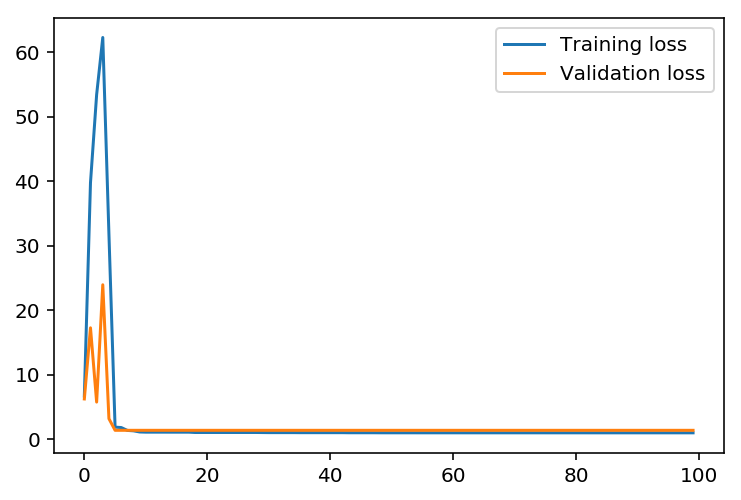

In [63]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

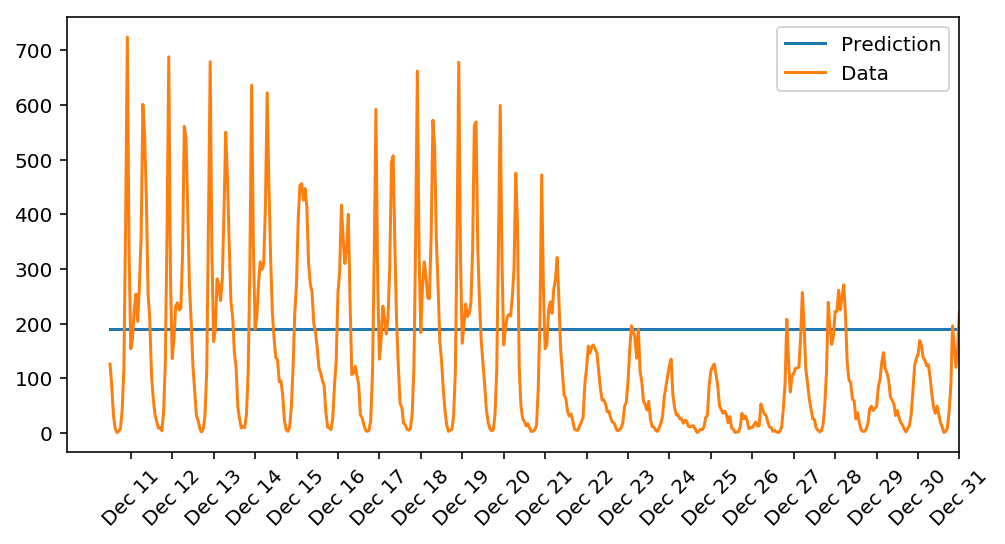

In [64]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below